In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from transformers import BertTokenizer, BertModel
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import AdamW, get_linear_schedule_with_warmup

/home/sourav/miniconda3/envs/rc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hyperperemeter

BATCH = 64
MAX_LENGTH = 256
EPOCH = 40
NUM_CLASSES = 24
DROPOUT = 0.5
L2_REG = 1e-5  


In [3]:

label_mapping = {'INFORMATION-TECHNOLOGY': 0,\
                 'ENGINEERING':1, \
                 'BUSINESS-DEVELOPMENT':2, \
                 'SALES':3,\
                 'HR':4, \
                 'FITNESS': 5 , \
                 'ARTS':6,\
                 'ADVOCATE':7,\
                 'CONSTRUCTION':8,\
                 'AVIATION':9,\
                 'FINANCE':10,\
                 'CHEF':11,\
                 'ACCOUNTANT':12,\
                 'BANKING':13,\
                 'HEALTHCARE':14,\
                 'CONSULTANT':15,\
                 'PUBLIC-RELATIONS':16,\
                 'DESIGNER':17, \
                 'TEACHER':18, \
                 'APPAREL':19, \
                 'DIGITAL-MEDIA':20,\
                 'AGRICULTURE':21, \
                 'AUTOMOBILE':22,\
                 'BPO':23
                 }

In [4]:
def labeling(label):
    return label_mapping[label]

In [5]:
train_data = pd.read_csv("data/dataset/train_aug.csv")
# val_data = pd.read_csv("data/dataset/val.csv")
test_data = pd.read_csv("data/dataset/test.csv")


train_data.dropna(inplace= True)
# val_data.dropna(inplace= True)
test_data.dropna(inplace= True)

train_data["Category"] = train_data["Category"].apply(labeling)
test_data["Category"] = test_data["Category"].apply(labeling)
# val_data["Category"] = val_data["Category"].apply(labeling) 

In [6]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
def generate_dataloader(df, tokenizer, max_length , batch_size):
    ids = np.zeros((len(df), max_length))
    masks = np.zeros((len(df), max_length))
    Y_labels = df['Category'].values

    for i, text in tqdm(enumerate(df['Resume_clean'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=max_length, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='pt'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    
    X_ids =  torch.tensor(ids, dtype=torch.long)
    X_masks = torch.tensor(masks, dtype=torch.long)
    Y_labels = torch.tensor(Y_labels, dtype=torch.long)
    dataset = TensorDataset(X_ids, X_masks, Y_labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [8]:
train_loader = generate_dataloader(train_data, tokenizer,max_length =MAX_LENGTH,batch_size = BATCH)
test_loader = generate_dataloader(test_data, tokenizer,max_length =MAX_LENGTH,batch_size = BATCH)


0it [00:00, ?it/s]

2250it [00:10, 223.98it/s]
563it [00:02, 225.02it/s]


In [9]:
# # Define the model architecture
# class TextModel(nn.Module):
#     def __init__(self, num_classes):
#         super(TextModel, self).__init__()
#         self.bert = model
#         self.intermediate_layer = nn.Linear(768, 512)
#         self.output_layer = nn.Linear(512, num_classes)
        
#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(input_ids, attention_mask=attention_mask)[1]
#         intermediate = self.intermediate_layer(outputs)
#         logits = self.output_layer(intermediate)
#         return logits

In [10]:
# Define the model architecture with dropout and L2 regularization
class TextModel(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.3, l2_reg=1e-5):
        super(TextModel, self).__init__()
        self.bert = model
        self.intermediate_layer = nn.Linear(768, 512)
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer added
        self.output_layer = nn.Linear(512, num_classes)
        
        # L2 regularization added to linear layers
        self.intermediate_layer.weight.data = nn.init.kaiming_normal_(self.intermediate_layer.weight.data)
        self.intermediate_layer.bias.data.fill_(0)
        self.output_layer.weight.data = nn.init.kaiming_normal_(self.output_layer.weight.data)
        self.output_layer.bias.data.fill_(0)
        
        self.l2_reg = l2_reg
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)[1]
        intermediate = self.intermediate_layer(outputs)
        intermediate = self.dropout(intermediate)  # Apply dropout
        logits = self.output_layer(intermediate)
        return logits

In [11]:
# Define the model architecture with dropout and L2 and L1 regularization
# class TextModel(nn.Module):
#     def __init__(self, num_classes, dropout_prob=0.3, l2_reg=1e-5, l1_reg=1e-5):
#         super(TextModel, self).__init__()
#         self.bert = model
#         self.intermediate_layer = nn.Linear(768, 512)
#         self.dropout = nn.Dropout(dropout_prob)  # Dropout layer added
#         self.output_layer = nn.Linear(512, num_classes)
        
#         # L2 regularization added to linear layers
#         self.intermediate_layer.weight.data = nn.init.kaiming_normal_(self.intermediate_layer.weight.data)
#         self.intermediate_layer.bias.data.fill_(0)
#         self.output_layer.weight.data = nn.init.kaiming_normal_(self.output_layer.weight.data)
#         self.output_layer.bias.data.fill_(0)
        
#         self.l2_reg = l2_reg
#         self.l1_reg = l1_reg
    
#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(input_ids, attention_mask=attention_mask)[1]
#         intermediate = self.intermediate_layer(outputs)
#         intermediate = self.dropout(intermediate)  # Apply dropout
#         logits = self.output_layer(intermediate)
#         return logits

#     def l1_loss(self):
#         l1_loss = torch.tensor(0.).to(device)
#         for param in self.parameters():
#             if param.dim() > 1:  # Only apply L1 regularization to linear layers
#                 l1_loss += torch.norm(param, p=1)  # L1 norm
#         return self.l1_reg * l1_loss

In [12]:

model = TextModel(NUM_CLASSES, dropout_prob=DROPOUT, l2_reg=L2_REG)

In [13]:
# # Instantiate the model with dropout, L2, and L1 regularization
# num_classes = 24
# dropout_prob = 0.3  # Adjust the dropout probability as needed
# l2_reg = 1e-5  # Adjust the L2 regularization strength as needed
# l1_reg = 1e-5  # Adjust the L1 regularization strength as needed
# model = TextModel(num_classes, dropout_prob=dropout_prob, l2_reg=l2_reg, l1_reg=l1_reg)


In [14]:
# Move the model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

TextModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [15]:
# Define the number of training steps
num_train_steps = len(train_loader) * EPOCH

In [16]:
# Calculate class weights
Y_labels = train_data['Category'].values
class_weights = torch.tensor([1.0 / count for count in np.bincount(Y_labels)], dtype=torch.float)
class_weights = class_weights.to(device)

In [17]:
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss(weight=class_weights) 
# criterion = nn.CrossEntropyLoss() 

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_train_steps)


In [18]:
# # Define early stopping and model checkpointing
# from sklearn.metrics import accuracy_score
# train_acc =[]
# valid_acc = []
# train_loss =[]


# best_val_accuracy = 0.0
# early_stopping_counter = 0

# # Training loop with early stopping and model checkpointing
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0.0
#     predictions = []
#     targets = []
#     print(f"---------Epoch:{epoch}----------")
#     for batch in tqdm(train_loader):
#         optimizer.zero_grad()
#         input_ids, attn_masks, labels = batch
#         input_ids, attn_masks, labels = input_ids.to(device), attn_masks.to(device), labels.to(device)
        
#         outputs = model(input_ids, attn_masks)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         predictions.extend(torch.argmax(outputs, dim=1).tolist())
#         targets.extend(labels.tolist())
#     avg_loss = total_loss / len(train_loader)
#     acc = accuracy_score(targets, predictions)

#     # Validation step
#     model.eval()
#     val_predictions = []
#     val_targets = []

#     with torch.no_grad():
#         for val_batch in tqdm(val_loader):
#             val_input_ids, val_attn_masks, val_labels = val_batch
#             val_input_ids, val_attn_masks, val_labels = val_input_ids.to(device), val_attn_masks.to(device), val_labels.to(device)
            
#             val_outputs = model(val_input_ids, val_attn_masks)
#             val_predictions.extend(torch.argmax(val_outputs, dim=1).tolist())
#             val_targets.extend(val_labels.tolist())

#     val_acc = accuracy_score(val_targets, val_predictions)

#     print(f"Epoch {epoch+1}/{num_epochs} - Avg. Loss: {avg_loss:.4f} - Accuracy: {acc:.4f} - Val Accuracy: {val_acc:.4f}")

#     # Check for early stopping
#     if acc > best_val_accuracy:
#         best_val_accuracy = acc
#         early_stopping_counter = 0
#         torch.save(model.state_dict(), f"model_ckpt/best_model_epoch_{epoch+1}_{val_acc}.pt")
#     else:
#         early_stopping_counter += 1
#         if early_stopping_counter >= 8:
#             print("Early stopping triggered.")
#             break
#     train_acc.append(acc)
#     train_loss.append(avg_loss)
#     valid_acc.append(val_acc)

In [19]:
# Define early stopping and model checkpointing
from sklearn.metrics import accuracy_score
train_acc =[]
valid_acc = []
train_loss =[]


best_val_accuracy = 0.0
early_stopping_counter = 0

# Training loop with early stopping and model checkpointing
for epoch in range(EPOCH):
    model.train()
    total_loss = 0.0
    predictions = []
    targets = []
    print(f"---------Epoch:{epoch}----------")
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids, attn_masks, labels = batch
        input_ids, attn_masks, labels = input_ids.to(device), attn_masks.to(device), labels.to(device)
        
        outputs = model(input_ids, attn_masks)
        loss = criterion(outputs, labels)
        
        # Apply L2 regularization to linear layers
        l2_loss = torch.tensor(0.).to(device)
        for param in model.parameters():
            if param.dim() > 1:  
                l2_loss += torch.norm(param, p=2)  # L2 norm
        loss += L2_REG * l2_loss
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions.extend(torch.argmax(outputs, dim=1).tolist())
        targets.extend(labels.tolist())
    avg_loss = total_loss / len(train_loader)
    acc = accuracy_score(targets, predictions)

    # Validation step
    model.eval()
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for val_batch in tqdm(test_loader):
            val_input_ids, val_attn_masks, val_labels = val_batch
            val_input_ids, val_attn_masks, val_labels = val_input_ids.to(device), val_attn_masks.to(device), val_labels.to(device)
            
            val_outputs = model(val_input_ids, val_attn_masks)
            val_predictions.extend(torch.argmax(val_outputs, dim=1).tolist())
            val_targets.extend(val_labels.tolist())

    val_acc = accuracy_score(val_targets, val_predictions)

    print(f"Epoch {epoch+1}/{EPOCH} - Avg. Loss: {avg_loss:.4f} - Accuracy: {acc:.4f} - Val Accuracy: {val_acc:.4f}")

    # Check for early stopping
    if acc > best_val_accuracy:
        best_val_accuracy = acc
        early_stopping_counter = 0
        torch.save(model.state_dict(), f"model_ckpt/best_model_epoch_{epoch+1}_{val_acc}.pt")
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 8:
            print("Early stopping triggered.")
            break
    train_acc.append(acc)
    train_loss.append(avg_loss)
    valid_acc.append(val_acc)

---------Epoch:0----------


  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:04<00:00,  2.13it/s]


Epoch 1/40 - Avg. Loss: 3.7594 - Accuracy: 0.0360 - Val Accuracy: 0.0515
---------Epoch:1----------


100%|██████████| 9/9 [00:04<00:00,  1.99it/s]


Epoch 2/40 - Avg. Loss: 3.2847 - Accuracy: 0.0556 - Val Accuracy: 0.1421
---------Epoch:2----------


100%|██████████| 9/9 [00:04<00:00,  1.90it/s]


Epoch 3/40 - Avg. Loss: 3.1293 - Accuracy: 0.1049 - Val Accuracy: 0.2753
---------Epoch:3----------


100%|██████████| 9/9 [00:04<00:00,  1.88it/s]


Epoch 4/40 - Avg. Loss: 2.8166 - Accuracy: 0.2284 - Val Accuracy: 0.5471
---------Epoch:4----------


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 5/40 - Avg. Loss: 2.2103 - Accuracy: 0.4382 - Val Accuracy: 0.6572
---------Epoch:5----------


100%|██████████| 9/9 [00:04<00:00,  1.85it/s]


Epoch 6/40 - Avg. Loss: 1.6476 - Accuracy: 0.6200 - Val Accuracy: 0.7460
---------Epoch:6----------


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 7/40 - Avg. Loss: 1.3415 - Accuracy: 0.7036 - Val Accuracy: 0.7513
---------Epoch:7----------


100%|██████████| 9/9 [00:04<00:00,  1.85it/s]


Epoch 8/40 - Avg. Loss: 1.1416 - Accuracy: 0.7680 - Val Accuracy: 0.7655
---------Epoch:8----------


100%|██████████| 9/9 [00:04<00:00,  1.85it/s]


Epoch 9/40 - Avg. Loss: 0.9552 - Accuracy: 0.7947 - Val Accuracy: 0.7940
---------Epoch:9----------


100%|██████████| 9/9 [00:04<00:00,  1.84it/s]


Epoch 10/40 - Avg. Loss: 0.8631 - Accuracy: 0.8124 - Val Accuracy: 0.7673
---------Epoch:10----------


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 11/40 - Avg. Loss: 0.8057 - Accuracy: 0.8347 - Val Accuracy: 0.7833
---------Epoch:11----------


100%|██████████| 9/9 [00:04<00:00,  1.85it/s]


Epoch 12/40 - Avg. Loss: 0.6978 - Accuracy: 0.8484 - Val Accuracy: 0.7975
---------Epoch:12----------


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 13/40 - Avg. Loss: 0.6067 - Accuracy: 0.8791 - Val Accuracy: 0.8011
---------Epoch:13----------


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 14/40 - Avg. Loss: 0.5364 - Accuracy: 0.8858 - Val Accuracy: 0.8135
---------Epoch:14----------


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 15/40 - Avg. Loss: 0.4749 - Accuracy: 0.8982 - Val Accuracy: 0.7940
---------Epoch:15----------


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 16/40 - Avg. Loss: 0.4165 - Accuracy: 0.9000 - Val Accuracy: 0.8046
---------Epoch:16----------


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 17/40 - Avg. Loss: 0.4084 - Accuracy: 0.9089 - Val Accuracy: 0.8046
---------Epoch:17----------


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 18/40 - Avg. Loss: 0.3370 - Accuracy: 0.9200 - Val Accuracy: 0.8011
---------Epoch:18----------


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 19/40 - Avg. Loss: 0.2941 - Accuracy: 0.9373 - Val Accuracy: 0.7993
---------Epoch:19----------


100%|██████████| 9/9 [00:04<00:00,  1.87it/s]


Epoch 20/40 - Avg. Loss: 0.2800 - Accuracy: 0.9382 - Val Accuracy: 0.8028
---------Epoch:20----------


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 21/40 - Avg. Loss: 0.2496 - Accuracy: 0.9400 - Val Accuracy: 0.8028
---------Epoch:21----------


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 22/40 - Avg. Loss: 0.2309 - Accuracy: 0.9556 - Val Accuracy: 0.8064
---------Epoch:22----------


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 23/40 - Avg. Loss: 0.2024 - Accuracy: 0.9622 - Val Accuracy: 0.8153
---------Epoch:23----------


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 24/40 - Avg. Loss: 0.1929 - Accuracy: 0.9578 - Val Accuracy: 0.7957
---------Epoch:24----------


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 25/40 - Avg. Loss: 0.1521 - Accuracy: 0.9698 - Val Accuracy: 0.8011
---------Epoch:25----------


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 26/40 - Avg. Loss: 0.1464 - Accuracy: 0.9720 - Val Accuracy: 0.7957
---------Epoch:26----------


100%|██████████| 9/9 [00:04<00:00,  1.87it/s]


Epoch 27/40 - Avg. Loss: 0.1312 - Accuracy: 0.9787 - Val Accuracy: 0.8046
---------Epoch:27----------


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 28/40 - Avg. Loss: 0.1257 - Accuracy: 0.9782 - Val Accuracy: 0.8028
---------Epoch:28----------


100%|██████████| 9/9 [00:04<00:00,  1.87it/s]


Epoch 29/40 - Avg. Loss: 0.1159 - Accuracy: 0.9818 - Val Accuracy: 0.8046
---------Epoch:29----------


100%|██████████| 9/9 [00:04<00:00,  1.87it/s]


Epoch 30/40 - Avg. Loss: 0.1174 - Accuracy: 0.9791 - Val Accuracy: 0.8082
---------Epoch:30----------


100%|██████████| 9/9 [00:04<00:00,  1.87it/s]


Epoch 31/40 - Avg. Loss: 0.0995 - Accuracy: 0.9862 - Val Accuracy: 0.8117
---------Epoch:31----------


100%|██████████| 9/9 [00:04<00:00,  1.87it/s]


Epoch 32/40 - Avg. Loss: 0.0832 - Accuracy: 0.9898 - Val Accuracy: 0.8117
---------Epoch:32----------


100%|██████████| 9/9 [00:04<00:00,  1.87it/s]


Epoch 33/40 - Avg. Loss: 0.0868 - Accuracy: 0.9898 - Val Accuracy: 0.8082
---------Epoch:33----------


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 34/40 - Avg. Loss: 0.0885 - Accuracy: 0.9871 - Val Accuracy: 0.8099
---------Epoch:34----------


100%|██████████| 9/9 [00:04<00:00,  1.87it/s]


Epoch 35/40 - Avg. Loss: 0.0771 - Accuracy: 0.9876 - Val Accuracy: 0.8135
---------Epoch:35----------


100%|██████████| 9/9 [00:04<00:00,  1.87it/s]


Epoch 36/40 - Avg. Loss: 0.0705 - Accuracy: 0.9920 - Val Accuracy: 0.8082
---------Epoch:36----------


100%|██████████| 9/9 [00:04<00:00,  1.87it/s]


Epoch 37/40 - Avg. Loss: 0.0700 - Accuracy: 0.9938 - Val Accuracy: 0.8117
---------Epoch:37----------


100%|██████████| 9/9 [00:04<00:00,  1.87it/s]


Epoch 38/40 - Avg. Loss: 0.0682 - Accuracy: 0.9920 - Val Accuracy: 0.8135
---------Epoch:38----------


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 39/40 - Avg. Loss: 0.0633 - Accuracy: 0.9933 - Val Accuracy: 0.8135
---------Epoch:39----------


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Epoch 40/40 - Avg. Loss: 0.0607 - Accuracy: 0.9947 - Val Accuracy: 0.8099


In [20]:
# # Define early stopping and model checkpointing
# from sklearn.metrics import accuracy_score
# train_acc =[]
# valid_acc = []
# train_loss =[]


# best_val_accuracy = 0.0
# early_stopping_counter = 0

# # Training loop with early stopping and model checkpointing
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0.0
#     predictions = []
#     targets = []
#     print(f"---------Epoch:{epoch}----------")
#     for batch in tqdm(train_loader):
#         optimizer.zero_grad()
#         input_ids, attn_masks, labels = batch
#         input_ids, attn_masks, labels = input_ids.to(device), attn_masks.to(device), labels.to(device)
        
#         outputs = model(input_ids, attn_masks)
#         loss = criterion(outputs, labels)
        
#         # Apply L2 and L1 regularization
#         l2_loss = torch.tensor(0.).to(device)
#         l1_loss = model.l1_loss()
#         for param in model.parameters():
#             if param.dim() > 1:
#                 l2_loss += torch.norm(param, p=2)
#         loss += l2_reg * l2_loss + l1_loss
        
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         predictions.extend(torch.argmax(outputs, dim=1).tolist())
#         targets.extend(labels.tolist())
#     avg_loss = total_loss / len(train_loader)
#     acc = accuracy_score(targets, predictions)

#     # Validation step
#     model.eval()
#     val_predictions = []
#     val_targets = []

#     with torch.no_grad():
#         for val_batch in tqdm(test_loader):
#             val_input_ids, val_attn_masks, val_labels = val_batch
#             val_input_ids, val_attn_masks, val_labels = val_input_ids.to(device), val_attn_masks.to(device), val_labels.to(device)
            
#             val_outputs = model(val_input_ids, val_attn_masks)
#             val_predictions.extend(torch.argmax(val_outputs, dim=1).tolist())
#             val_targets.extend(val_labels.tolist())

#     val_acc = accuracy_score(val_targets, val_predictions)

#     print(f"Epoch {epoch+1}/{num_epochs} - Avg. Loss: {avg_loss:.4f} - Accuracy: {acc:.4f} - Val Accuracy: {val_acc:.4f}")

#     # Check for early stopping
#     if acc > best_val_accuracy:
#         best_val_accuracy = acc
#         early_stopping_counter = 0
#         torch.save(model.state_dict(), f"model_ckpt/best_model_epoch_{epoch+1}_{val_acc}.pt")
#     else:
#         early_stopping_counter += 1
#         if early_stopping_counter >= 8:
#             print("Early stopping triggered.")
#             break
#     train_acc.append(acc)
#     train_loss.append(avg_loss)
#     valid_acc.append(val_acc)

In [21]:
len(train_loss)

40

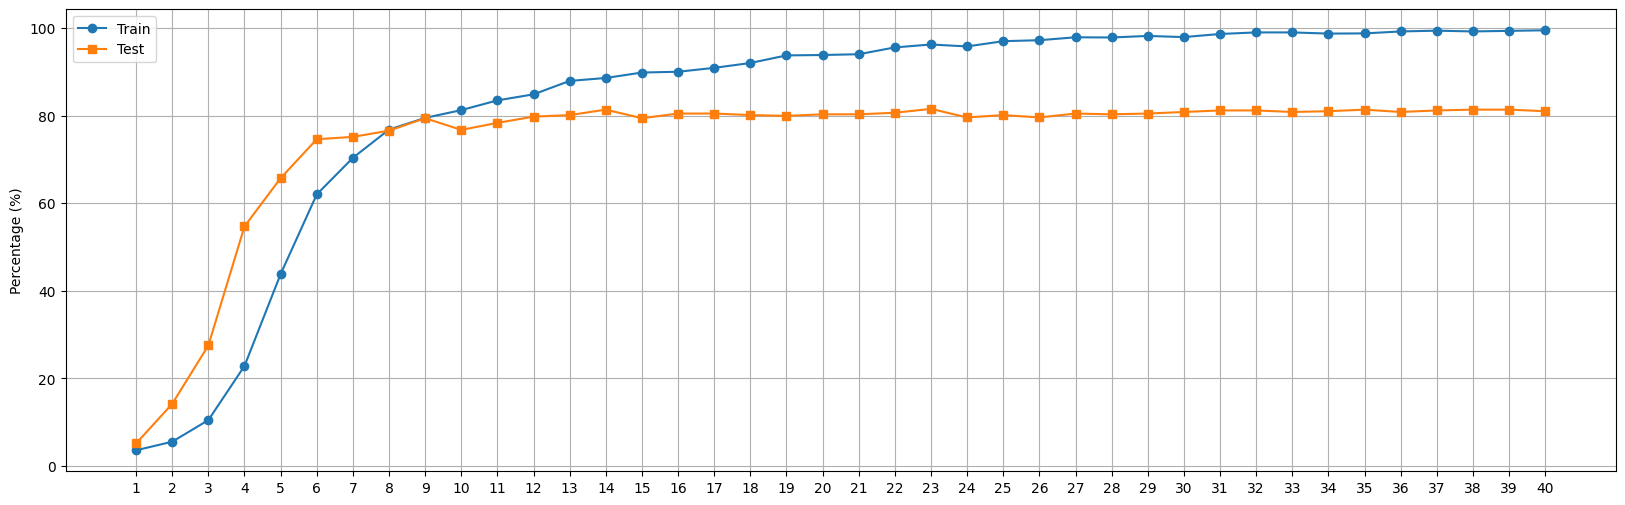

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: replace these with your actual data
list1 = train_acc  
list2 = valid_acc  

# Calculate percentages for each value in the lists
percentages1 = [100 * value  for value in list1]
percentages2 = [100 * value  for value in list2]

# Create a list of index positions for the x-axis
x = np.arange(len(list1))

# Set the figure size
plt.figure(figsize=(20, 6))  

# Create the line graph
plt.plot(x, percentages1, marker='o', label='Train')
plt.plot(x, percentages2, marker='s', label='Test')

# Set x-axis ticks and labels
plt.xticks(x, range(1, len(list1) + 1))

# Set y-axis label as a percentage
plt.ylabel('Percentage (%)')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


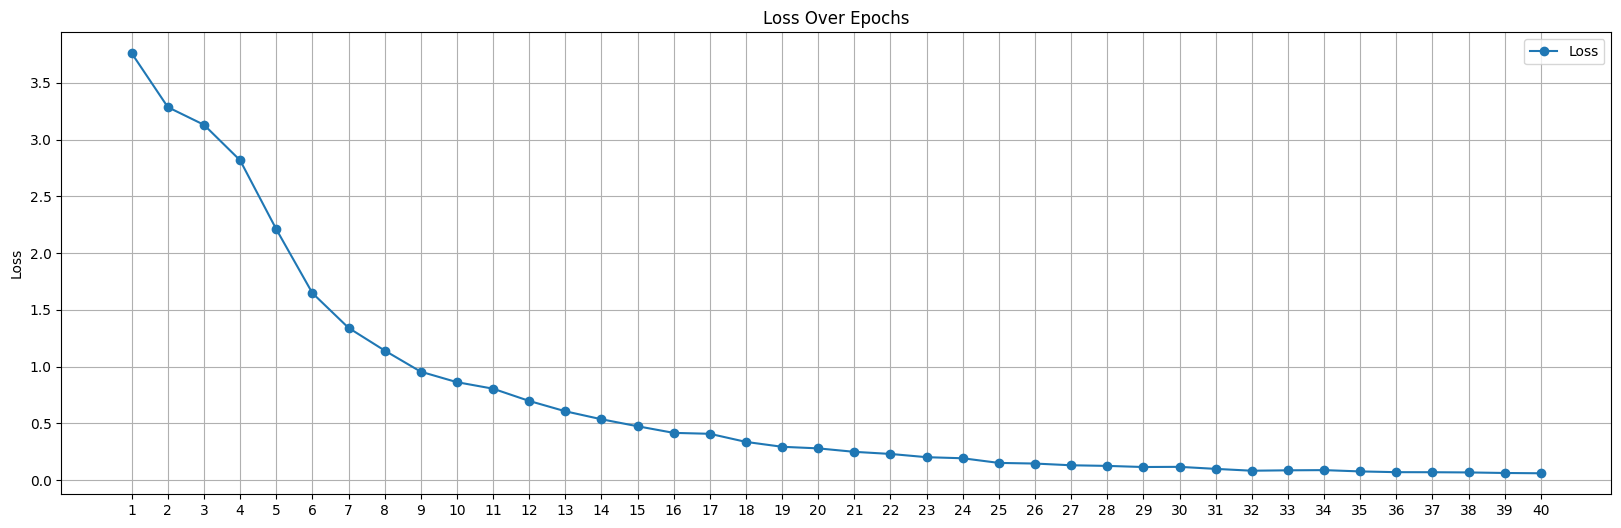

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Example loss values: replace this with your actual data
loss_list = train_loss  # Replace with your data

# Create a list of index positions for the x-axis
x = np.arange(len(loss_list))

# Set the figure size
plt.figure(figsize=(20, 6))  # Adjust the width and height as needed

# Create the line graph
plt.plot(x, loss_list, marker='o', label='Loss')

# Set x-axis ticks and labels
plt.xticks(x, range(1, len(loss_list) + 1))

# Set y-axis label
plt.ylabel('Loss')

# Add a title
plt.title('Loss Over Epochs')

# Show the plot
plt.grid(True)
plt.legend()
plt.show()


In [25]:
model_root = BertModel.from_pretrained('bert-base-cased')

# Define the model architecture with dropout and L2 regularization
class TextModel(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.3, l2_reg=1e-5):
        super(TextModel, self).__init__()
        self.bert = model_root
        self.intermediate_layer = nn.Linear(768, 512)
        self.dropout = nn.Dropout(dropout_prob)
        self.output_layer = nn.Linear(512, num_classes)
        
        # L2 regularization added to linear layers
        self.intermediate_layer.weight.data = nn.init.kaiming_normal_(self.intermediate_layer.weight.data)
        self.intermediate_layer.bias.data.fill_(0)
        self.output_layer.weight.data = nn.init.kaiming_normal_(self.output_layer.weight.data)
        self.output_layer.bias.data.fill_(0)
        
        self.l2_reg = l2_reg
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)[1]
        intermediate = self.intermediate_layer(outputs)
        intermediate = self.dropout(intermediate)
        logits = self.output_layer(intermediate)
        return logits


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
ckpt = "/home/sourav/srv_project/resume-categorization/model_ckpt/best_model_epoch_32_0.8117229129662522.pt"
# Load the trained model checkpoint
model = TextModel(num_classes=24)
model.to(device)
model.load_state_dict(torch.load(ckpt))
model.eval()

test_predictions = []
test_targets = []

with torch.no_grad():
    for test_batch in tqdm(test_loader):
        test_input_ids, test_attn_masks, test_labels = test_batch
        test_input_ids, test_attn_masks, test_labels = test_input_ids.to(device), test_attn_masks.to(device), test_labels.to(device)
        
        test_outputs = model(test_input_ids, test_attn_masks)
        test_predictions.extend(torch.argmax(test_outputs, dim=1).tolist())
        test_targets.extend(test_labels.tolist())

test_acc = accuracy_score(test_targets, test_predictions)
test_precision = precision_score(test_targets, test_predictions, average='weighted')
test_recall = recall_score(test_targets, test_predictions, average='weighted')
test_f1 = f1_score(test_targets, test_predictions, average='weighted')

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")


100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

Test Accuracy: 0.8117
Test Precision: 0.8139
Test Recall: 0.8117
Test F1-score: 0.8088
